/home/lcastri/miniconda3/envs/pyAgrum/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/lcastri/miniconda3/envs/pyAgrum/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/lcastri/miniconda3/envs/pyAgrum/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


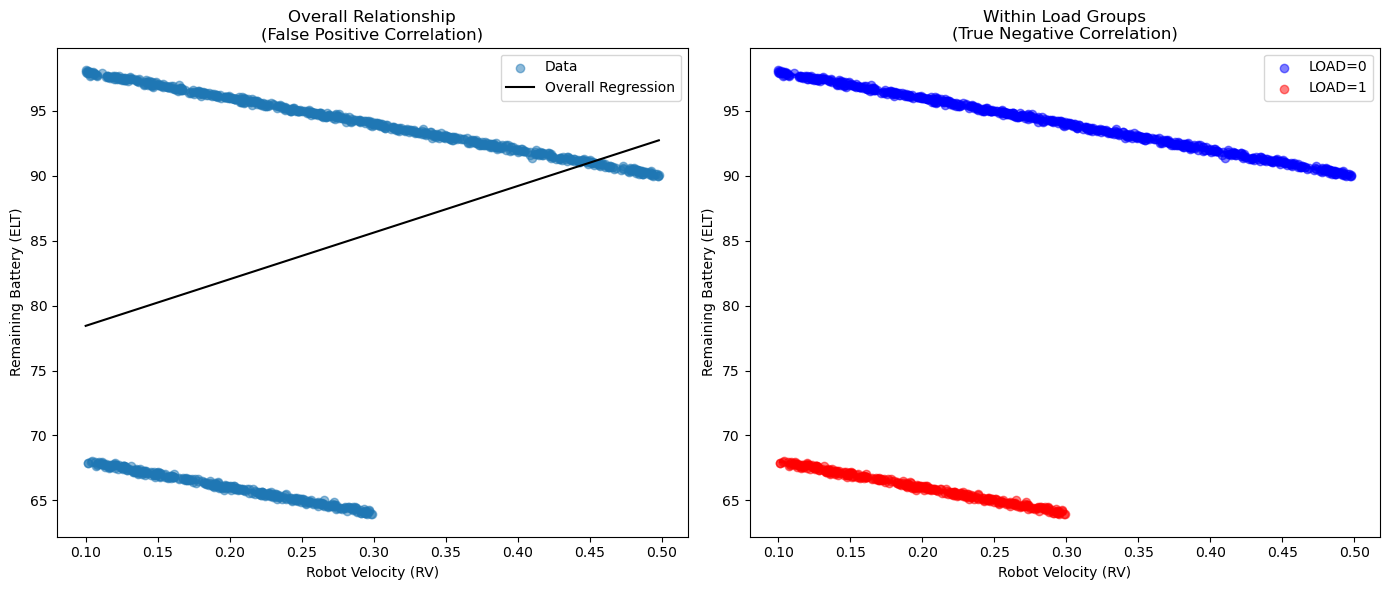

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate time series data
np.random.seed(42)
n_samples = 1000
time = np.linspace(0, 10, n_samples)

# People Density (PD) varies with time
people_density = np.abs(np.sin(time * 2) + 0.2 * np.random.normal(size=n_samples))

# LOAD depends on People Density (more likely to carry during crowded times)
LOAD = (people_density > 0.8).astype(int)  # 1 = loaded, 0 = unloaded

# Robot Velocity (RV) depends on LOAD
RV = np.where(
    LOAD == 1,
    np.random.uniform(0.1, 0.3, n_samples),  # Slow when loaded
    np.random.uniform(0.1, 0.5, n_samples)   # Fast when unloaded
)

# Battery drain dynamics
ELT = np.clip(
    100 - (RV * 20 + LOAD * 30 + 0.1 * np.random.normal(size=n_samples)),
    0, 100
)

# Create DataFrame
df = pd.DataFrame({
    "Time": time,
    "PD": people_density,
    "LOAD": LOAD,
    "RV": RV,
    "ELT": ELT
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# -------------------------------------------------
# 1) Overall Relationship (misleading)
# -------------------------------------------------
ax1.scatter(df["RV"], df["ELT"], alpha=0.5, label="Data")
ax1.set_title("Overall Relationship\n(False Positive Correlation)")
ax1.set_xlabel("Robot Velocity (RV)")
ax1.set_ylabel("Remaining Battery (ELT)")

# Fit a single linear regression ignoring LOAD
model_all = LinearRegression()
model_all.fit(df[["RV"]], df["ELT"])

# Predict across the full RV range
x_all = np.linspace(df["RV"].min(), df["RV"].max(), 100)
y_all = model_all.predict(x_all.reshape(-1, 1))

# Plot the overall regression line
ax1.plot(x_all, y_all, color="black", label="Overall Regression")
ax1.legend()

# -------------------------------------------------
# 2) Within-group relationships (true negative slopes)
# -------------------------------------------------
colors = {0: "blue", 1: "red"}

for load_val in [0, 1]:
    subset = df[df["LOAD"] == load_val]
    ax2.scatter(subset["RV"], subset["ELT"], color=colors[load_val], alpha=0.5, label=f"LOAD={load_val}")

    # Fit regression within this LOAD group
    model_group = LinearRegression()
    model_group.fit(subset[["RV"]], subset["ELT"])
    x_g = np.linspace(subset["RV"].min(), subset["RV"].max(), 100)
    y_g = model_group.predict(x_g.reshape(-1, 1))

    ax2.plot(x_g, y_g, color=colors[load_val], linewidth=2)

ax2.set_title("Within Load Groups\n(True Negative Correlation)")
ax2.set_xlabel("Robot Velocity (RV)")
ax2.set_ylabel("Remaining Battery (ELT)")
ax2.legend()

plt.tight_layout()
plt.show()
